In [2]:
from sklearn.preprocessing import StandardScaler
from pandas import DataFrame

def scale_all_dataframe(data: DataFrame) -> DataFrame:
    vars: list[str] = data.columns.to_list()
    transf: StandardScaler = StandardScaler().fit(data)
    df = DataFrame(transf.transform(data), index=data.index)
    df.columns = vars
    return df

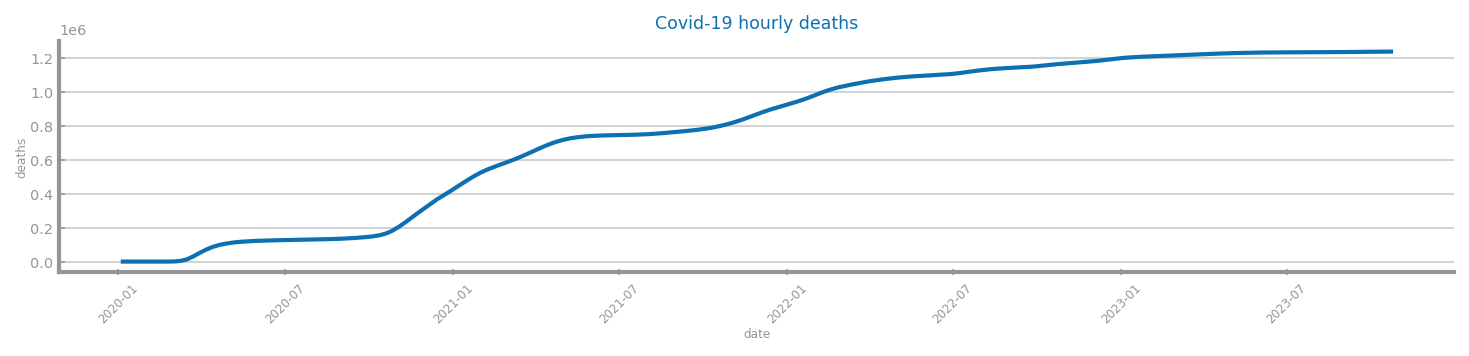

In [4]:
from pandas import read_csv, Series
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_line_chart, HEIGHT

file_tag = "Covid-19"
filename = "data/time_series/forecast_covid_single.csv"
index = "date"
target = "deaths"
data: DataFrame = read_csv(
    filename,
    index_col=index,
    sep=",",
    decimal=".",
    parse_dates=True,
    infer_datetime_format=True,
)
series: Series = data[target]

figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} hourly {target}",
)
show()

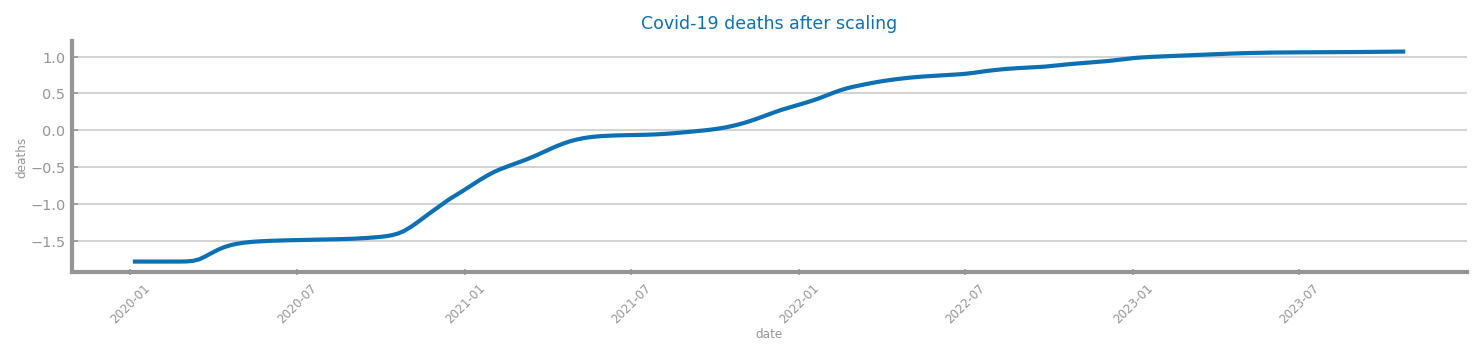

In [5]:
df: DataFrame = scale_all_dataframe(data)

ss: Series = df[target]
figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    ss.index.to_list(),
    ss.to_list(),
    xlabel=ss.index.name,
    ylabel=target,
    title=f"{file_tag} {target} after scaling",
)
show()

In [10]:
timecol = "date"
data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
data.sort_index(inplace=True)
# data.index.freq = 'W'

data_roll = data.rolling(window = 25).mean()
data_roll.dropna(inplace=True)
data_diff = data_roll.diff()
data_diff.dropna(inplace=True)
data: DataFrame = scale_all_dataframe(data_diff)
series: Series = data[target]

In [64]:
from matplotlib.axes import Axes
from matplotlib.pyplot import subplots
from numpy import sqrt
from config import FUTURE_COLOR, PAST_COLOR, PRED_FUTURE_COLOR
from dslabs_functions import FORECAST_MEASURES, plot_multibar_chart


def plot_forecasting_eval(trn: Series, tst: Series, prd_trn: Series, prd_tst: Series, title: str = "", axs = None) -> list[Axes]:
    ev1: dict = {
        "RMSE": [sqrt(FORECAST_MEASURES["MSE"](trn, prd_trn)), sqrt(FORECAST_MEASURES["MSE"](tst, prd_tst))],
        "MAE": [FORECAST_MEASURES["MAE"](trn, prd_trn), FORECAST_MEASURES["MAE"](tst, prd_tst)],
    }
    ev2: dict = {
        "MAPE": [FORECAST_MEASURES["MAPE"](trn, prd_trn), FORECAST_MEASURES["MAPE"](tst, prd_tst)],
        "R2": [FORECAST_MEASURES["R2"](trn, prd_trn), FORECAST_MEASURES["R2"](tst, prd_tst)],
    }

    # print(eval1, eval2)
    if axs is None:
        fig, axs = subplots(1, 2, figsize=(1.5 * HEIGHT, 0.75 * HEIGHT), squeeze=True)
        fig.suptitle(title)
    else:
        axs[0].set_title(title)
    plot_multibar_chart(["train", "test"], ev1, ax=axs[0], title=f"Scale-dependent error ({title})", percentage=False)
    plot_multibar_chart(["train", "test"], ev2, ax=axs[1], title=f"Percentage error ({title})", percentage=True)

    return axs

def plot_forecasting_series(
    trn: Series,
    tst: Series,
    prd_tst: Series,
    title: str = "",
    xlabel: str = "time",
    ylabel: str = "",
    ax = None
) -> list[Axes]:
    if ax is None:
        fig, ax = subplots(1, 1, figsize=(4 * HEIGHT, HEIGHT), squeeze=True)
        fig.suptitle(title)
    else:
        ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.plot(trn.index, trn.values, label="train", color=PAST_COLOR)
    ax.plot(tst.index, tst.values, label="test", color=FUTURE_COLOR)
    ax.plot(prd_tst.index, prd_tst.values, "--", label="test prediction", color=PRED_FUTURE_COLOR)
    ax.legend(prop={"size": 5})

    return ax


from numpy import arange
from pandas import DataFrame, Series
from sklearn.linear_model import LinearRegression
from dslabs_functions import series_train_test_split


def lin(agg_df):
    train, test = series_train_test_split(agg_df, trn_pct=0.90)

    trnX = arange(len(train)).reshape(-1, 1)
    trnY = train.to_numpy()
    tstX = arange(len(train), len(agg_df)).reshape(-1, 1)
    tstY = test.to_numpy()

    model = LinearRegression()
    model.fit(trnX, trnY)

    prd_trn: Series = Series(model.predict(trnX), index=train.index)
    prd_tst: Series = Series(model.predict(tstX), index=test.index)

    return train, test, prd_trn, prd_tst

In [69]:
from matplotlib.pyplot import savefig, subplots
from matplotlib.axes import Axes
from matplotlib.figure import Figure

fig: Figure
axs: list[Axes]


models = {
    "Linear Regression": lin,
}

model = "Linear Regression"

scaling = [False, True]

fig, axs = subplots(nrows=len(scaling), ncols=1, figsize=(10, 15))
fig.suptitle(f"{file_tag} - Scaling Plots - Linear Regression")

def alter(data):
    df = data

    df = df.rolling(window = 25).mean()
    df.dropna(inplace=True)
    df = df.diff()
    df = df.diff()
    df.dropna(inplace=True)

    if scaling[s]:
        df: DataFrame = scale_all_dataframe(df)
    
    series: Series = df[target]
    return df, series

for s in range(len(scaling)):

    data = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
    df, series = alter(data)
    
    train, test, prd_trn, prd_tst = models[model](df)

    plot_forecasting_series(train, test, prd_tst, title=f"Linear Regression - {target} - {file_tag} - {'scaling' if scaling[s] else 'not scalling'}", ax=axs[s])
savefig(f"images/{file_tag}_{model}_scaling_plots.png")

fig, axs = subplots(nrows=len(scaling), ncols=2, figsize=(10, 15))
fig.suptitle(f"{file_tag} - Scaling Results - Linear Regression")

for s in range(len(scaling)):
    data = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
    df, series = alter(data)
    train, test, prd_trn, prd_tst = models[model](df)
    plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"Linear Regression - {target} - {file_tag} - {'scaling' if scaling[s] else 'not scalling'}", axs=axs[s])
savefig(f"images/{file_tag}_{model}_scaling_eval.png")
# show()

AttributeError: 'numpy.ndarray' object has no attribute 'set_title'